In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/project"
#if not os.path.exists(datadir):
!ln -s "/content/drive/My Drive/CS444DLforCV/project" $datadir # TODO: Fill your Assignment 3 path
os.chdir(datadir)
!pwd

/content/drive/My Drive/CS444DLforCV/project


In [80]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.models import resnet18, ResNet18_Weights
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn.functional as F
import torch.nn as nn
import json
from pathlib import Path
import os
import time

In [81]:
transform_train = transforms.Compose([
                                 transforms.CenterCrop(28),
                                 transforms.ToTensor(),
                                 transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])
transform_test = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                             ])



In [82]:
datasettrain = FashionMNIST('input/fashionMNIST', train=True, download=True, transform=transform_train)
datasettest = FashionMNIST('input/fashionMNIST', train=False, download=True, transform=transform_test)


In [83]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [84]:
trainloader = torch.utils.data.DataLoader(datasettrain, batch_size=256, shuffle=True)

testloader = torch.utils.data.DataLoader(datasettest, batch_size=256, shuffle=True)

In [85]:
class MNIST_MODEL(nn.Module):
    def __init__(self):
        super(MNIST_MODEL, self).__init__()
        self.conv1 = nn.Conv2d(1, 24, 5, 1)
        self.conv2 = nn.Conv2d(24, 32, 3, 1)
        self.fc1 = nn.Linear(800, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 800)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x=  F.log_softmax(x, dim=1)
        return x

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = MNIST_MODEL()
net = net.to(device)

In [87]:
num_epochs = 5
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, betas=(0.7, 0.9))
scheduler = OneCycleLR(optimizer, max_lr=1e-2,total_steps=int((len(datasettrain)-1)//256 + 1)*num_epochs, cycle_momentum=False)

In [88]:
def run_test(net, testloader, criterion):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            correct += (torch.max(outputs,1)[1] == labels).sum().item()
            total += labels.size()[0]
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [89]:
def train(net, criterion, optimizer, num_epochs):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, labels) in enumerate(trainloader):
            images, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(images)
            predicted = torch.max(outputs,1)[1]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            print_freq = 100
            running_loss += loss.item()

            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        net.eval()
        run_test(net, testloader, criterion)

    print('Finished Training')

In [76]:
train(net, criterion, optimizer, num_epochs=num_epochs)

[1,   100] loss: 0.275 acc: 89.80 time: 20.55
[1,   200] loss: 0.298 acc: 89.02 time: 22.00
TESTING:
Accuracy of the network on the 10000 test images: 85.54 %
Average loss on the 10000 test images: 0.437
[2,   100] loss: 0.319 acc: 88.21 time: 20.85
[2,   200] loss: 0.328 acc: 88.11 time: 21.65
TESTING:
Accuracy of the network on the 10000 test images: 87.95 %
Average loss on the 10000 test images: 0.343
[3,   100] loss: 0.282 acc: 89.66 time: 21.21
[3,   200] loss: 0.271 acc: 89.95 time: 20.41
TESTING:
Accuracy of the network on the 10000 test images: 88.50 %
Average loss on the 10000 test images: 0.334
[4,   100] loss: 0.217 acc: 92.00 time: 21.60
[4,   200] loss: 0.196 acc: 92.70 time: 20.53
TESTING:
Accuracy of the network on the 10000 test images: 91.15 %
Average loss on the 10000 test images: 0.268
[5,   100] loss: 0.144 acc: 94.68 time: 21.78
[5,   200] loss: 0.138 acc: 94.87 time: 20.45
TESTING:
Accuracy of the network on the 10000 test images: 91.49 %
Average loss on the 10000

In [77]:
torch.save(net.state_dict(), "./models/mnist_model.pth")

In [90]:
net = MNIST_MODEL()
net.load_state_dict(torch.load("./models/mnist_model.pth"))
net = net.to(device)
net.eval()

MNIST_MODEL(
  (conv1): Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [91]:
def integrated_gradients(input, referenceImage, net, label):
    gradAvg = 0

    estIterations = 100

    for i in range(estIterations):
        x = referenceImage
        x = x + ((i+1) / estIterations) * (input - referenceImage)
        x.requires_grad = True

        output = net(x)
        predictProbab = output[0, label]

        grad = torch.autograd.grad(predictProbab, x)[0]
        gradAvg += grad / estIterations

    gradients = gradAvg * (input - referenceImage)

    return gradients


In [92]:
def save_and_show_output(images, label, directory):
    fig, axs = plt.subplots(1, 2)
    fig.set_figheight(10)
    fig.set_figwidth(10)

    axs[0].imshow(images[0], cmap="Greys")
    axs[0].axis("off")
    axs[0].set_title(label)
    axs[1].imshow(images[1])
    axs[1].set_title("Integrated Gradient")
    axs[1].axis("off")
    fig.tight_layout()
    plt.savefig(directory)


In [93]:
igloader = torch.utils.data.DataLoader(datasettest, batch_size=1, shuffle=True)

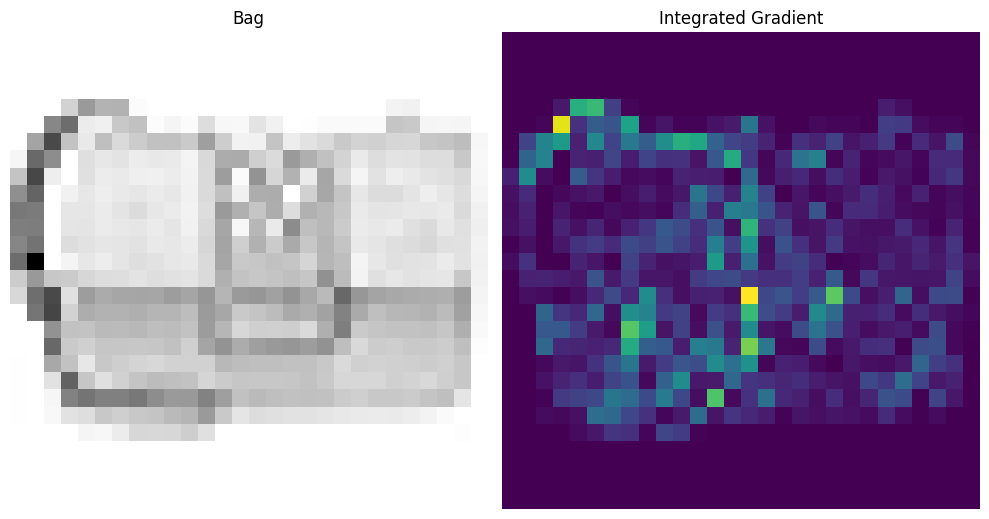

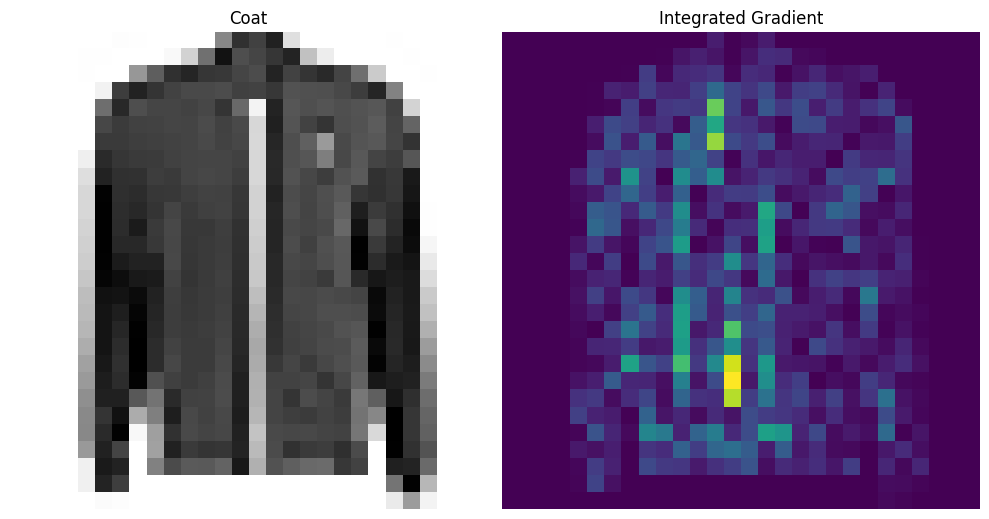

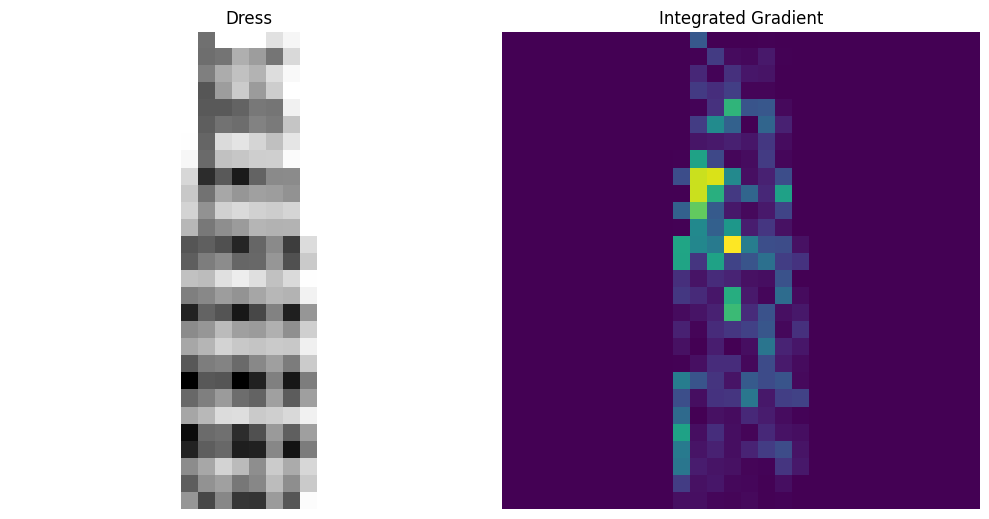

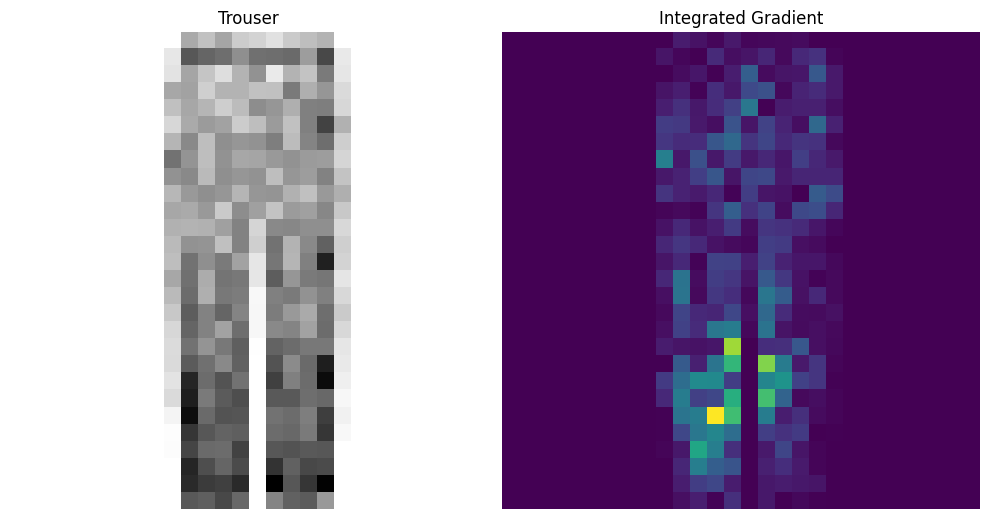

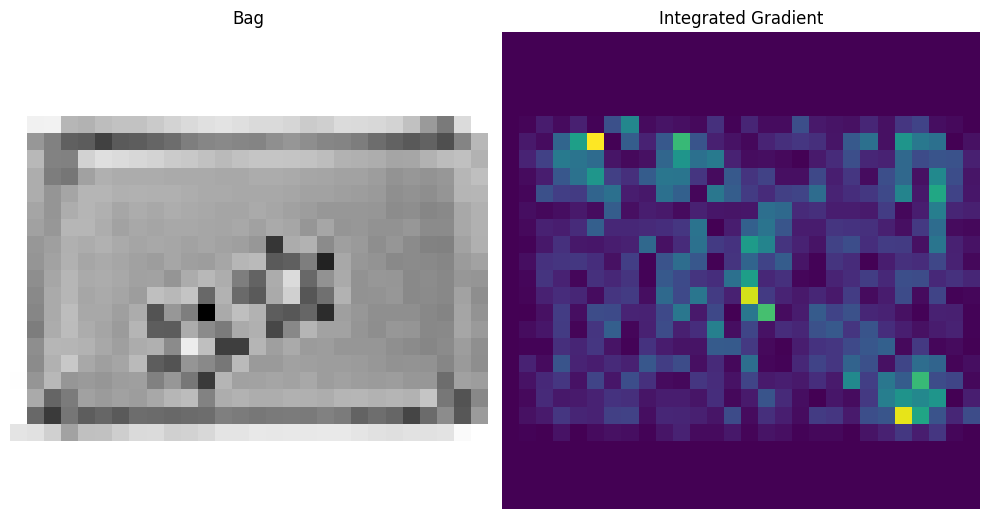

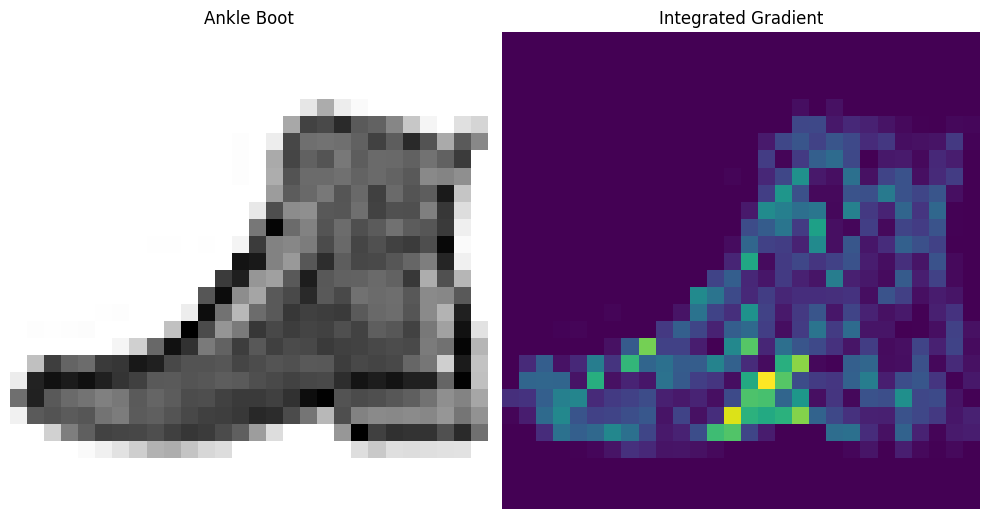

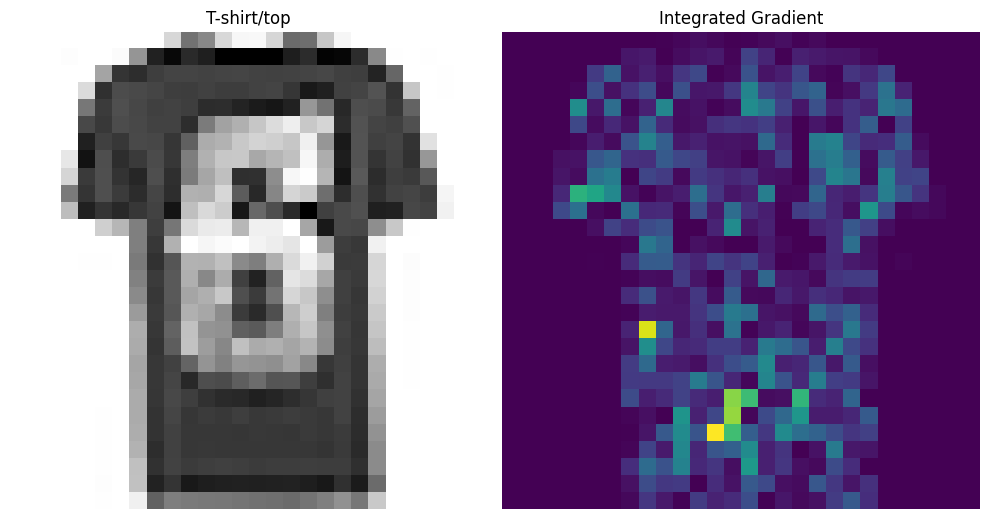

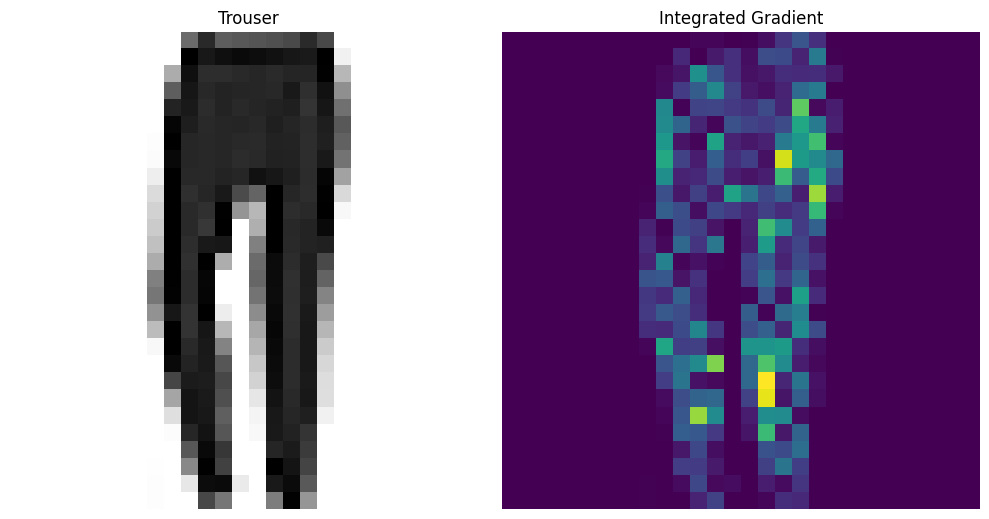

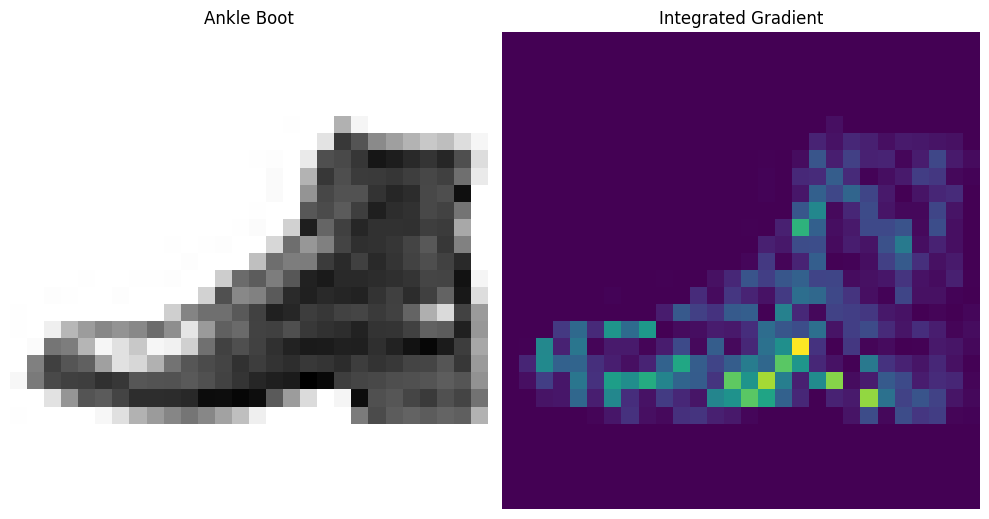

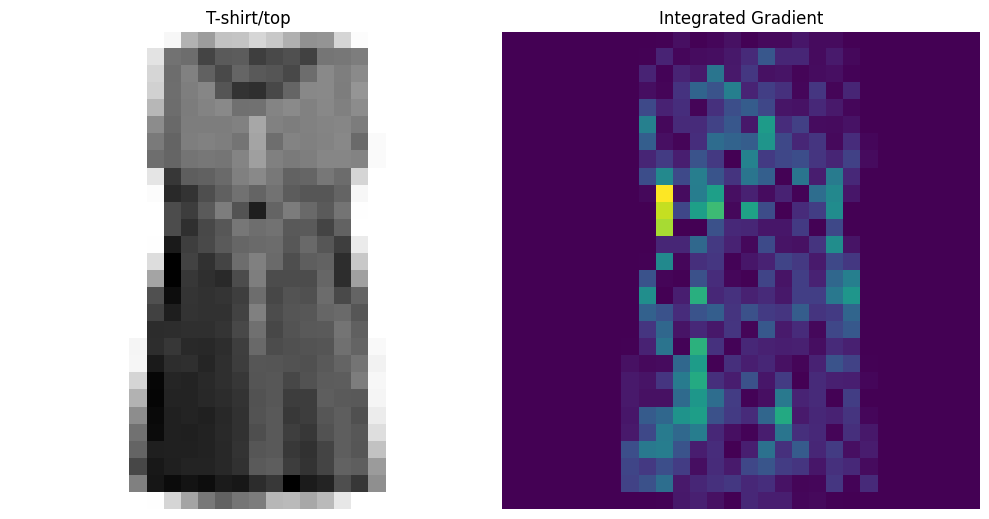

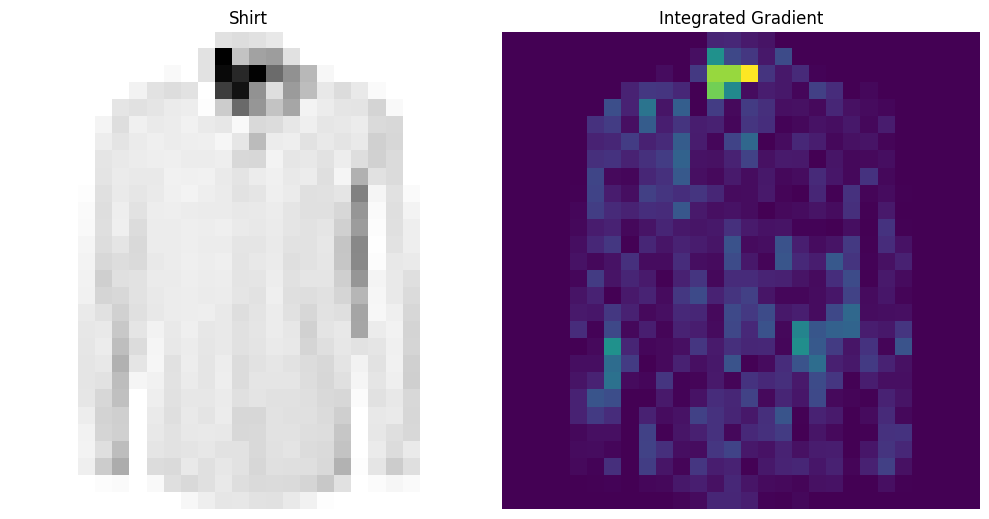

In [94]:
referenceImage = np.zeros((28, 28, 1), dtype=np.float32)
referenceImageProc = transform_test(referenceImage).unsqueeze(0)
index = 0
for image, label in igloader:
  image = image.to(device)
  label = label.to(device)
  gradients = integrated_gradients(image, referenceImageProc, net, label)
  gradients = gradients.squeeze(0)
  gradients = gradients.permute(1, 2, 0)
  imagerecon = image.squeeze(0)
  imagerecon = transforms.Normalize((0,), (1/0.5,))(imagerecon)
  imagerecon = transforms.Normalize((-0.5,), (1,))(imagerecon)
  imagerecon.permute(1, 2, 0)
  imagerecon = imagerecon.squeeze(0)

  gradientsCpu = np.fabs(gradients.cpu().data.numpy())
  gradientsCpu = gradientsCpu / np.max(gradientsCpu)

  images = [imagerecon.cpu().data.numpy(), gradientsCpu]

  save_and_show_output(images, classes[label], "output/test"+ str(index) + ".jpeg")
  index +=1
  if(index>10):
    break
